In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import re
import pickle
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from os import listdir
from os.path import isfile, join

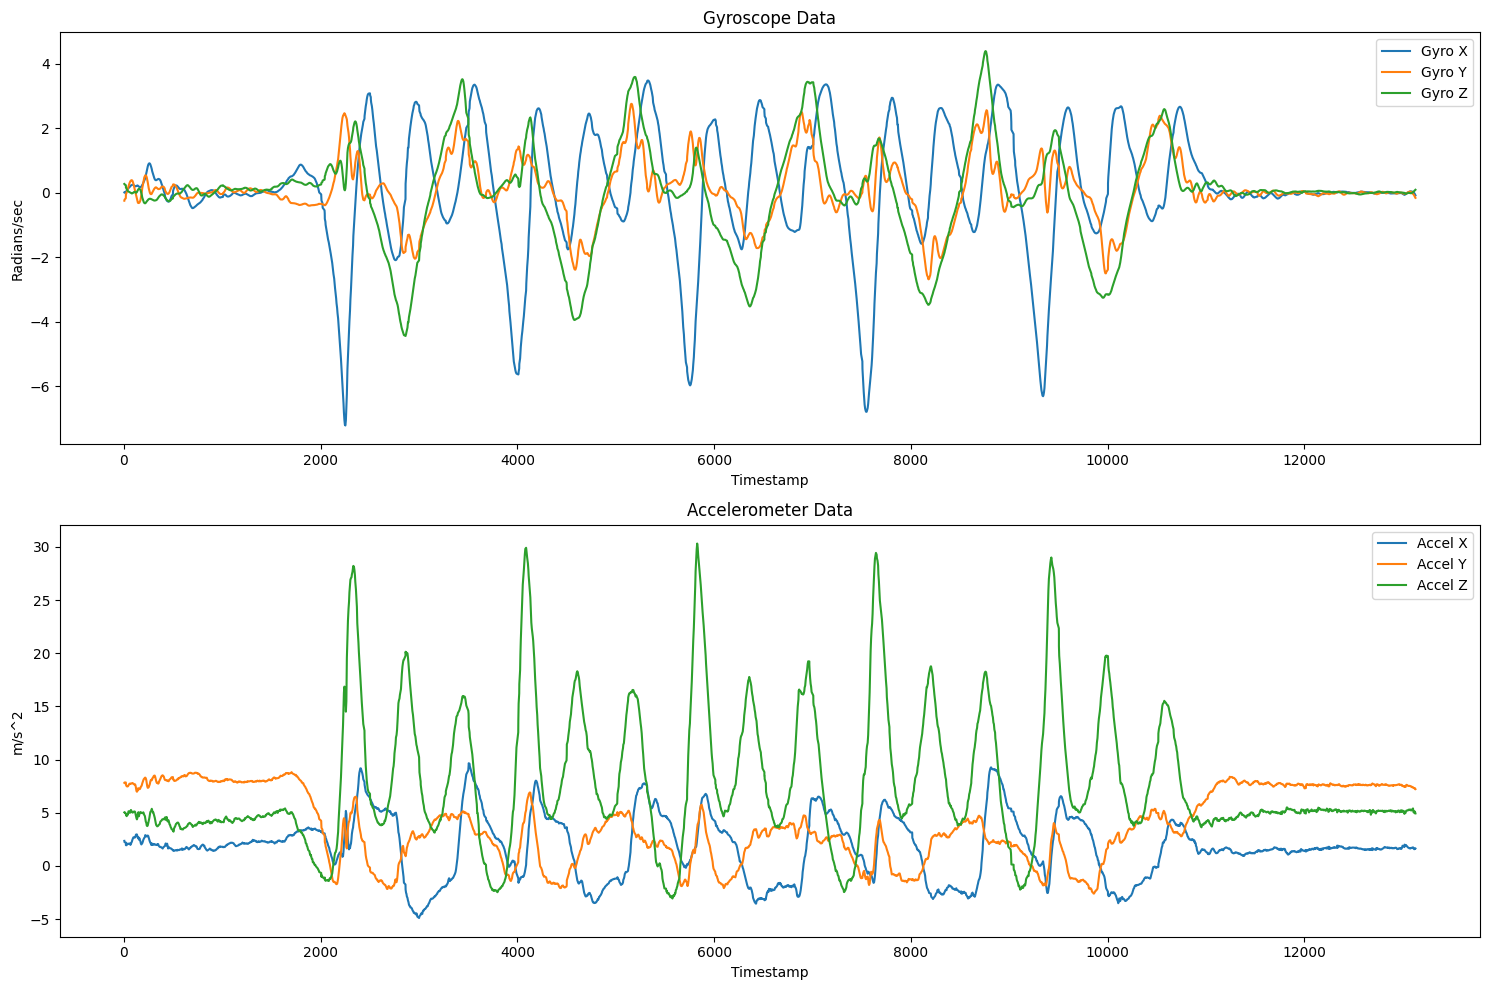

In [3]:
##### CELL 1 #####
# This cell is to load and visualize the IMU Data given to us by the professor

def load_data(folder_path):
    files = [f for f in os.listdir(folder_path) if isfile(join(folder_path, f)) and not f.startswith('.')]
    data_frames = []
    labels = []
    for file in files:
        match = re.match(r'(beat[34])|([a-zA-Z]+)', os.path.splitext(file)[0])
        gesture_label = match.group() if match else 'unknown' #This takes the first part of the filename and creates a label with it
        df = pd.read_csv(join(folder_path, file), sep='\t', header=None, encoding='latin1')
        # print(f"File: {file} -> Number of columns: {df.shape[1]}") #For Debugging
        if df.shape[1] == 7:
            df.columns = ['ts', 'Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']
            df['label'] = gesture_label
            data_frames.append(df)
            labels.append(gesture_label) #Appends the label to the array 
    return data_frames, labels

def plot_imu_data(df):
    plt.figure(figsize=(15, 10))

    df['ts'] = pd.to_numeric(df['ts'], errors='coerce')

    plt.subplot(2, 1, 1)
    plt.plot(df['ts'], df['Wx'], label ='Gyro X')
    plt.plot(df['ts'], df['Wy'], label ='Gyro Y')
    plt.plot(df['ts'], df['Wz'], label ='Gyro Z')
    plt.title('Gyroscope Data')
    plt.xlabel('Timestamp')
    plt.ylabel('Radians/sec')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df['ts'], df['Ax'], label ='Accel X')
    plt.plot(df['ts'], df['Ay'], label ='Accel Y')
    plt.plot(df['ts'], df['Az'], label ='Accel Z')
    plt.title('Accelerometer Data')
    plt.xlabel('Timestamp')
    plt.ylabel('m/s^2')
    plt.legend()


    plt.tight_layout()
    plt.show()

##IMPORTANT TO CHANGE##
data_frames, labels = load_data('RepeatedGestureTraining')

if data_frames:
    plot_imu_data(data_frames[0])




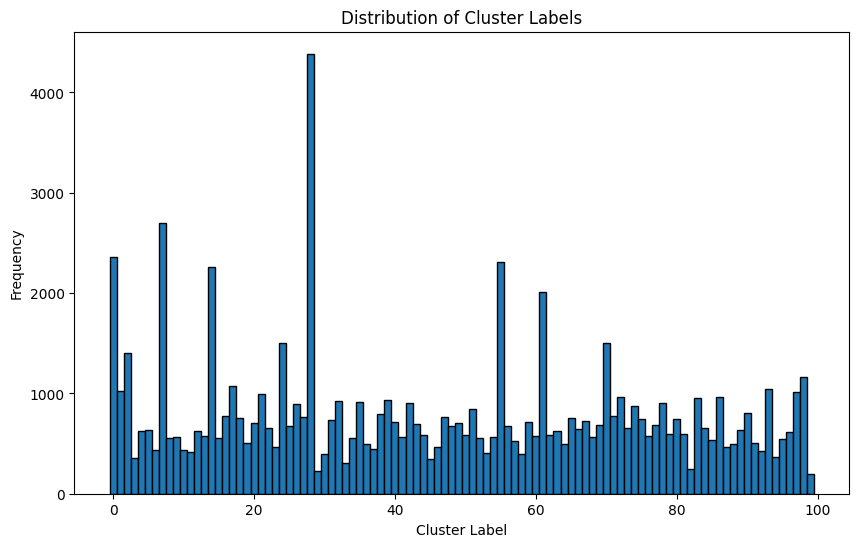

In [4]:
##### CELL 2 #####
# This cell is to discretize the raw sensor data using k-means clustering to transform coninuous observations

combined_data = pd.concat(data_frames, ignore_index=True)

#Selecting what features to use for clustering
features = combined_data[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(features_imputed)

combined_data['cluster'] = kmeans.labels_

for i, df in enumerate(data_frames):
    start_idx = sum(len(df) for df in data_frames[:i])
    end_idx = start_idx + len(df)
    df['cluster'] = combined_data.iloc[start_idx:end_idx]['cluster'].values

plt.figure(figsize=(10,6))
plt.hist(combined_data['cluster'], bins=np.arange(kmeans.n_clusters+1)-0.5, edgecolor='black')
plt.title('Distribution of Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.show()

In [5]:
##### Cell 3 #####
#This cell is to initialize the parameters that will be used in my HMM application 

#Constants
N = 15  # Number of states
M = 100  # Number of observation symbols
max_iter = 10  # Maximum number of iterations for training

#Initialize dictionaries to hold the data frames and parameters for each motion type
data_frames_by_motion = {motion: [] for motion in ['wave', 'inf', 'eight', 'circle', 'beat3', 'beat4']}
hmm_params_by_motion = {motion: {'A': None, 'B': None, 'pi': None} for motion in data_frames_by_motion}

for df in data_frames:
    gesture_type = df['label'].iloc[0]
    data_frames_by_motion[gesture_type].append(df)

    
#Initializing the A, B, and pi for each motion's HMM
for motion in data_frames_by_motion:
    A = np.random.rand(N, N)
    A /= A.sum(axis=1, keepdims=True)
    B = np.random.rand(N, M)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.random.rand(N)
    pi /= pi.sum()
    hmm_params_by_motion[motion] = {'A': A, 'B': B, 'pi': pi}



In [6]:
##### CELL 4 #####
#This cell is to implement the custom HMM and Baum-Welch algorithm 

def forward(O, A, B, pi):
    N = A.shape[0]
    T = len(O)
    alpha = np.zeros((T, N))
    alpha[0, :] = np.log(pi + 1e-10) + np.log(B[:, O[0]] + 1e-10)

    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.logaddexp.reduce(alpha[t-1] + np.log(A[:, j] + 1e-10)) + np.log(B[j, O[t]] + 1e-10)
    return alpha

def backward(O, A, B):
    N = A.shape[0]
    T = len(O)
    beta = np.zeros((T, N))
    beta[-1, :] = 0  # log(1) = 0

    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.logaddexp.reduce(np.log(A[i, :] + 1e-10) + np.log(B[:, O[t+1]] + 1e-10) + beta[t+1, :])
    return beta

def baum_welch(O, A, B, pi, max_iter=max_iter, min_diff=1e-4, min_iters=5):
    N = A.shape[0]
    M = B.shape[1]
    T = len(O)
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = forward(O, A, B, pi)
        beta = backward(O, A, B)

        log_likelihood = np.logaddexp.reduce(alpha[-1])
        log_likelihoods.append(log_likelihood)
        print(f"Iteration {iteration}, Log Likelihood: {log_likelihood}")

        # Calculate gamma
        gamma = np.exp(alpha + beta - np.logaddexp.reduce(alpha + beta, axis=1, keepdims=True))

        # Update pi
        pi_new = gamma[0, :] / np.sum(gamma[0, :])

        # Update A
        xi_sum = np.zeros((N, N))
        for t in range(T-1):
            xi_t = np.exp(alpha[t, :, None] + np.log(A) + np.log(B[:, O[t+1]]) + beta[t+1] - np.logaddexp.reduce(alpha[t] + beta[t]))
            xi_sum += np.sum(xi_t, axis=0)  # Summing over time for xi
        A_new = xi_sum / np.sum(xi_sum, axis=1, keepdims=True)

        # Update B
        B_new = np.zeros((N, M))
        for k in range(M):
            mask = np.array(O) == k
            B_new[:, k] = np.sum(gamma[mask, :], axis=0)
        B_new /= np.sum(gamma, axis=0).reshape(-1, 1)

        # Check for convergence
        if iteration >= min_iters and np.linalg.norm(A_new - A) < min_diff and np.linalg.norm(B_new - B) < min_diff:
            print(f"Convergence reached at iteration {iteration}")
            break

        A_new = np.clip(A_new, 1e-10, np.inf)
        B_new = np.clip(B_new, 1e-10, np.inf)

        A, B, pi = A_new, B_new, pi_new

    return A, B, pi, log_likelihoods




Training HMM for wave motion...
Iteration 0, Log Likelihood: -67529.62460870053
Iteration 1, Log Likelihood: -41150.7159092337
Iteration 2, Log Likelihood: -41150.493140845756
Iteration 3, Log Likelihood: -41150.36792403992
Iteration 4, Log Likelihood: -41150.29558737374
Iteration 5, Log Likelihood: -41150.25033389191
Iteration 6, Log Likelihood: -41150.21951763541
Iteration 7, Log Likelihood: -41150.19677983628
Iteration 8, Log Likelihood: -41150.17866766321
Iteration 9, Log Likelihood: -41150.16316492688
Training HMM for inf motion...
Iteration 0, Log Likelihood: -57455.17235118666
Iteration 1, Log Likelihood: -36902.913593719524
Iteration 2, Log Likelihood: -36902.80275655165
Iteration 3, Log Likelihood: -36902.75392074417
Iteration 4, Log Likelihood: -36902.727282934124
Iteration 5, Log Likelihood: -36902.71042667818
Iteration 6, Log Likelihood: -36902.69866589392
Iteration 7, Log Likelihood: -36902.68994605149
Iteration 8, Log Likelihood: -36902.683229066315
Iteration 9, Log Likel

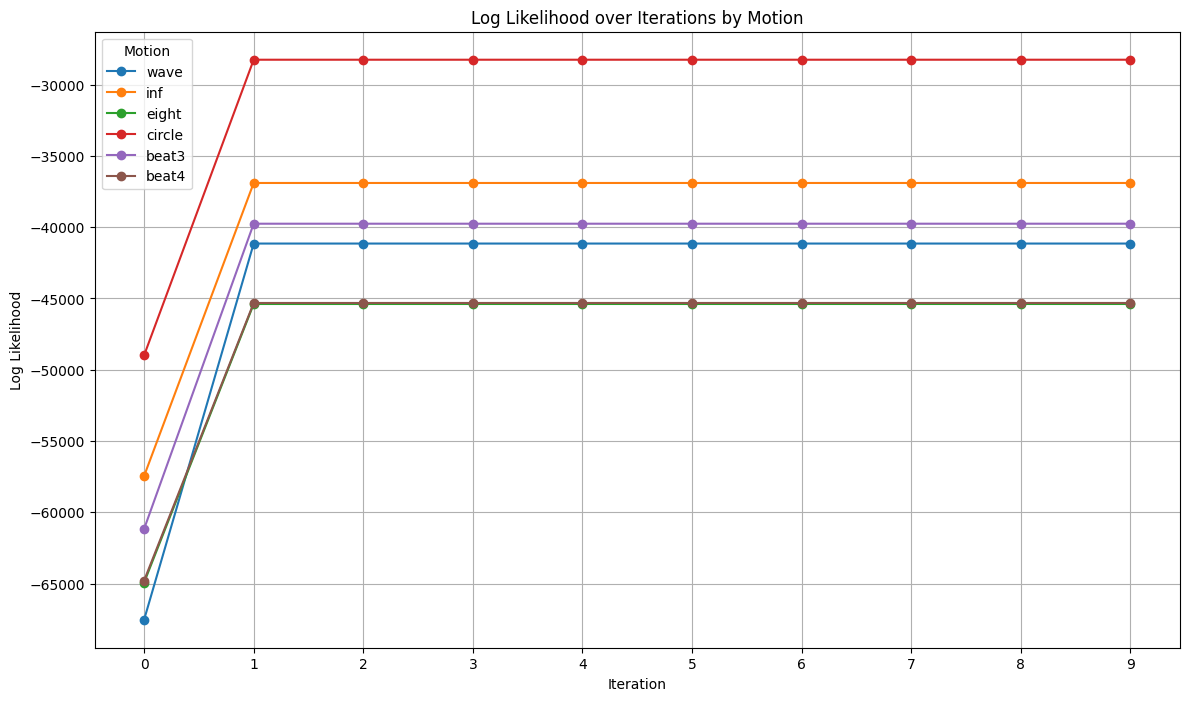

In [10]:
##### CELL 5 #####
#This cell is to plot the log likelihood over iterations

log_likelihoods_by_motion = {}
trained_models_by_motion = {}

##IMPORTANT TO CHANGE##
#Path to the directory where the models are saved
save_dir = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project2/trained_models/'

for motion, dfs in data_frames_by_motion.items():
    if dfs:
        print(f"Training HMM for {motion} motion...")

        O = np.concatenate([df['cluster'].astype(int).values for df in dfs])

        #The transition probabilities 
        A, B, pi = (hmm_params_by_motion[motion]['A'], 
                    hmm_params_by_motion[motion]['B'], 
                    hmm_params_by_motion[motion]['pi'])
        
        # Train the HMM
        A_motion, B_motion, pi_motion, log_likelihoods_motion = baum_welch(O, A, B, pi, max_iter=max_iter)
        
        # Store the trained model and log likelihoods
        trained_models_by_motion[motion] = (A_motion, B_motion, pi_motion)
        log_likelihoods_by_motion[motion] = log_likelihoods_motion

        #Saves the trained model to disk
        with open(f'{save_dir}trained_model_{motion}.pkl', 'wb') as f:
            pickle.dump((A_motion, B_motion, pi_motion), f)

        #Saves the log likelihoods to disk
        with open(f'{save_dir}trained_model_{motion}_log_likelihoods.pkl', 'wb') as f:
            pickle.dump(log_likelihoods_motion, f)
        

    else:
        print(f"No data for {motion} motion.")

# Plotting the log likelihoods
plt.figure(figsize=(14, 8))
for motion, log_likelihoods in log_likelihoods_by_motion.items():
    plt.plot(range(len(log_likelihoods)), log_likelihoods, marker='o', linestyle='-', label=motion)

plt.title('Log Likelihood over Iterations by Motion')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.xticks(range(0, max_iter, max(1, max_iter//10)))
plt.legend(title="Motion")
plt.grid(True)
plt.show()

In [11]:
##### CELL 6 #####
#This cell is to preprocess each file in the test data to create the observation sequences
# based on the same k-means model trained on the training data

##IMPORTANT TO CHANGE##
single_gesture_data, _ = load_data('SingleGestureTraining')

test_data_clusters = {}
for df in single_gesture_data:
    features = df[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]
    features_imputed = imputer.transform(features)  # Using the imputer fitted on the training data
    clusters = kmeans.predict(features_imputed)  # Using the kmeans fitted on the training data
    filename = df['label'].iloc[0]  
    test_data_clusters[filename] = clusters


In [13]:
##### CELL 7 #####
#This cell is to Test the models on each file's observation sequence and store the log-likelihoods

log_likelihoods_test_data = {filename: {} for filename in test_data_clusters.keys()}

##IMPORTANT TO CHANGE##
#Path to the directory where the models are saved
models_path = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project2/trained_models'

for filename, O_single in test_data_clusters.items():
    for motion, (A_motion, B_motion, pi_motion) in trained_models_by_motion.items():
       
        with open(f'{models_path}/trained_model_{motion}.pkl', 'rb') as file:
            A_motion, B_motion, pi_motion = pickle.load(file)
       
        alpha_single = forward(O_single, A_motion, B_motion, pi_motion)
        log_likelihood_single = np.logaddexp.reduce(alpha_single[-1])
        log_likelihoods_test_data[filename][motion] = log_likelihood_single



In [14]:
##### CELL 8 #####
#This cell is to compare the results and print the top 3 predictions for each test file

for filename, likelihoods in log_likelihoods_test_data.items():
    print(f"Results for {filename}:")
    # Sort the log-likelihoods in descending order
    sorted_likelihoods = sorted(likelihoods.items(), key=lambda item: item[1], reverse=True)
    for rank, (motion, log_likelihood) in enumerate(sorted_likelihoods[:3]):
        print(f"  {rank + 1}: {motion} with log-likelihood {log_likelihood}")
    print("\n")



Results for eight:
  1: eight with log-likelihood -1962.4021424582393
  2: inf with log-likelihood -7238.725091190014
  3: beat3 with log-likelihood -10380.35389149489


Results for beat4:
  1: beat4 with log-likelihood -2355.420372946492
  2: beat3 with log-likelihood -3589.940506289552
  3: wave with log-likelihood -11141.217526203547


Results for beat3:
  1: beat3 with log-likelihood -1861.2572478144598
  2: beat4 with log-likelihood -2278.9044560623825
  3: wave with log-likelihood -9980.837411562616


Results for circle:
  1: circle with log-likelihood -1624.5009714373878
  2: beat4 with log-likelihood -6720.277674200058
  3: beat3 with log-likelihood -8048.575039937671


Results for wave:
  1: wave with log-likelihood -2570.2234972704873
  2: beat3 with log-likelihood -4995.559161451805
  3: beat4 with log-likelihood -5558.579879642917


Results for inf:
  1: inf with log-likelihood -2287.5591001763833
  2: eight with log-likelihood -9615.541940821955
  3: beat3 with log-likelih

In [29]:
##### CELL 9 #####
#This cell is to preprocess each file in the RELEASED test data to create the observation sequences
# based on the same k-means model trained on the training data

##IMPORTANT TO CHANGE##
released_gesture_data, _ = load_data('ECE5242Proj2-test')

released_test_data_clusters = {}
for df in released_gesture_data:
    features = df[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]
    features_imputed = imputer.transform(features)  # Using the imputer fitted on the training data
    clusters = kmeans.predict(features_imputed)  # Using the kmeans fitted on the training data
    filename = df['label'].iloc[0]  
    released_test_data_clusters[filename] = clusters

In [30]:
##### CELL 10 #####
#This cell is to Test the RELEASED models on each file's observation sequence and store the log-likelihoods

Released_log_likelihoods_test_data = {filename: {} for filename in released_test_data_clusters.keys()}

for filename, O_single in released_test_data_clusters.items():
    for motion, (A_motion, B_motion, pi_motion) in trained_models_by_motion.items():
        alpha_single = forward(O_single, A_motion, B_motion, pi_motion)
        log_likelihood_single = np.logaddexp.reduce(alpha_single[-1])
        Released_log_likelihoods_test_data[filename][motion] = log_likelihood_single



In [31]:
##### CELL 11 #####
#This cell is to compare the results and print the top 3 predictions for each RELEASED test file

for filename, likelihoods in Released_log_likelihoods_test_data.items():
    print(f"Results for {filename}:")
    # Sort the log-likelihoods in descending order
    sorted_likelihoods = sorted(likelihoods.items(), key=lambda item: item[1], reverse=True)
    for rank, (motion, log_likelihood) in enumerate(sorted_likelihoods[:3]):
        print(f"  {rank + 1}: {motion} with log-likelihood {log_likelihood}")
    print("\n")

Results for testTwo:
  1: beat4 with log-likelihood -2570.462777605
  2: beat3 with log-likelihood -2880.366260704149
  3: inf with log-likelihood -10550.095896177521


Results for testSix:
  1: eight with log-likelihood -2406.7351515868745
  2: inf with log-likelihood -7729.743344750919
  3: wave with log-likelihood -11020.198683148476


Results for testThree:
  1: inf with log-likelihood -2588.863739196283
  2: eight with log-likelihood -9871.81978779002
  3: beat3 with log-likelihood -13697.848873757956


Results for testFour:
  1: beat4 with log-likelihood -2583.5829548210318
  2: beat3 with log-likelihood -2815.5855489229875
  3: wave with log-likelihood -12379.856294128129


Results for testOne:
  1: inf with log-likelihood -2420.9439242157846
  2: eight with log-likelihood -8106.439096438073
  3: beat3 with log-likelihood -11667.055422334844


Results for testSeven:
  1: wave with log-likelihood -1076.4793331267028
  2: eight with log-likelihood -5917.494718951386
  3: beat3 wit